In [1]:
import pandas as pd
import numpy as np

# Encontrar o path onde estão armazenadas as funções
import sys
sys.path.insert(0, '../')


In [2]:

from src_23.transformation_layer.transformation import *
from src_23.utils.plots import plot_volume_diario,plot_picos_regiao
from src_23.utils.plots import plot_dados_regiao,decompor_series

# Leitura e análise inicial dos dados

In [3]:
path_raw_data = '../data/raw/covid_19_data.csv'
df = pd.read_csv(path_raw_data, parse_dates = ['ObservationDate','Last Update'])
df

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
26708,26709,2020-05-19,Wyoming,US,2020-05-20 02:32:19,776.0,10.0,0.0
26709,26710,2020-05-19,Xinjiang,Mainland China,2020-05-20 02:32:19,76.0,3.0,73.0
26710,26711,2020-05-19,Yukon,Canada,2020-05-20 02:32:19,11.0,0.0,11.0
26711,26712,2020-05-19,Yunnan,Mainland China,2020-05-20 02:32:19,185.0,2.0,183.0


In [4]:
df = df.drop(['SNo','Last Update'],axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26713 entries, 0 to 26712
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ObservationDate  26713 non-null  datetime64[ns]
 1   Province/State   12879 non-null  object        
 2   Country/Region   26713 non-null  object        
 3   Confirmed        26713 non-null  float64       
 4   Deaths           26713 non-null  float64       
 5   Recovered        26713 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 1.2+ MB


In [6]:
round(100*df.isnull().sum()/len(df),2).sort_values(ascending=False)

Province/State     51.79
ObservationDate     0.00
Country/Region      0.00
Confirmed           0.00
Deaths              0.00
Recovered           0.00
dtype: float64

- Aproximadamente **51.8%** dos dados de províncias e estados **são dados faltantes**.

Se o escopo for a nível **nacional/regional** a origem específica de cada fonte de dados não afetará o modelo de previsão.

In [7]:
df.duplicated().replace(False,np.nan).dropna()

C:\Users\pablo\AppData\Local\Temp\ipykernel_5816\3290960273.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.duplicated().replace(False,np.nan).dropna()


Series([], dtype: float64)

- Sem dados duplicados

# Data Transformation e EDA (Nível global)

In [8]:
df.head()

,ObservationDate,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,2020-01-22,Anhui,Mainland China,1.0,0.0,0.0
1,2020-01-22,Beijing,Mainland China,14.0,0.0,0.0
2,2020-01-22,Chongqing,Mainland China,6.0,0.0,0.0
3,2020-01-22,Fujian,Mainland China,1.0,0.0,0.0
4,2020-01-22,Gansu,Mainland China,0.0,0.0,0.0


In [9]:
paises_regioes_unicas= df['Country/Region'].unique()
len(paises_regioes_unicas)

223


Adaptando índice de reprodução:

- $\beta$: Taxa de infecção
- $\gamma$: Taxa de recuperação
- $\mu$: Taxa de mortalidade

Reproduction rate = $\frac{\beta}{\gamma + \mu}$[$^{[1]}$](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7438206/)

In [10]:
df_transformed = transformation_pipeline(df)
df_transformed

,Country/Region,ObservationDate,Confirmed,Recovered,Deaths,New_Confirmed,New_Recovered,New_Deaths,Confirmed_rate,Recovered_rate,Deaths_rate,Reproduction_rate
0,Azerbaijan,2020-02-28,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"('St. Martin',)",2020-03-10,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Afghanistan,2020-02-24,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Afghanistan,2020-02-25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Afghanistan,2020-02-26,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
14696,occupied Palestinian territory,2020-03-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14697,occupied Palestinian territory,2020-03-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14698,occupied Palestinian territory,2020-03-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14699,occupied Palestinian territory,2020-03-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


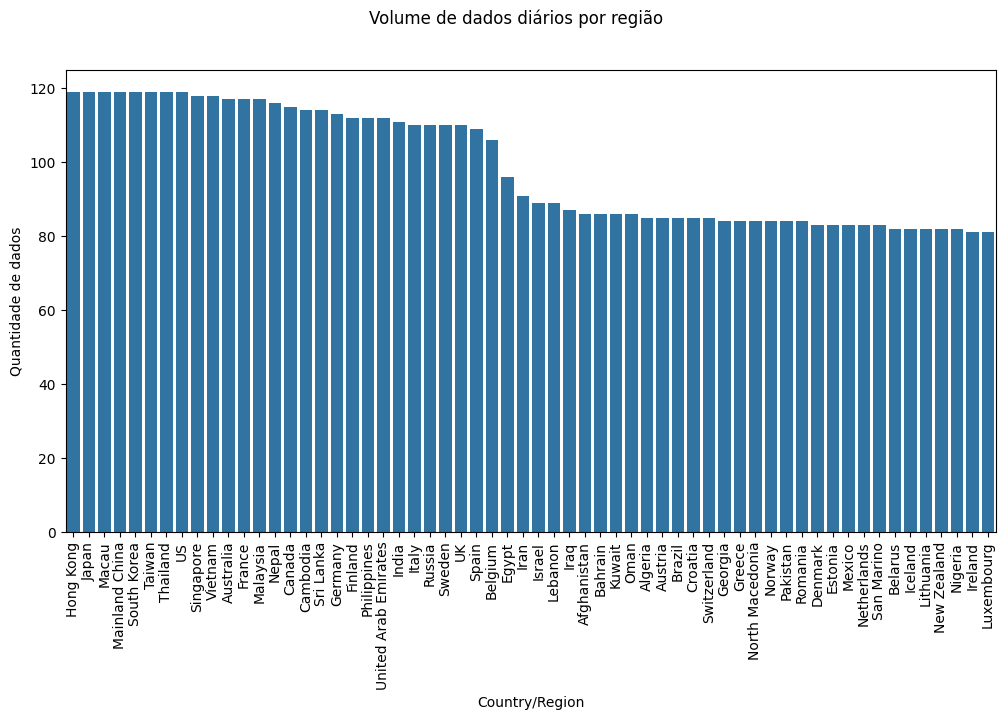

In [11]:
plot_volume_diario(df_transformed,largests=60)

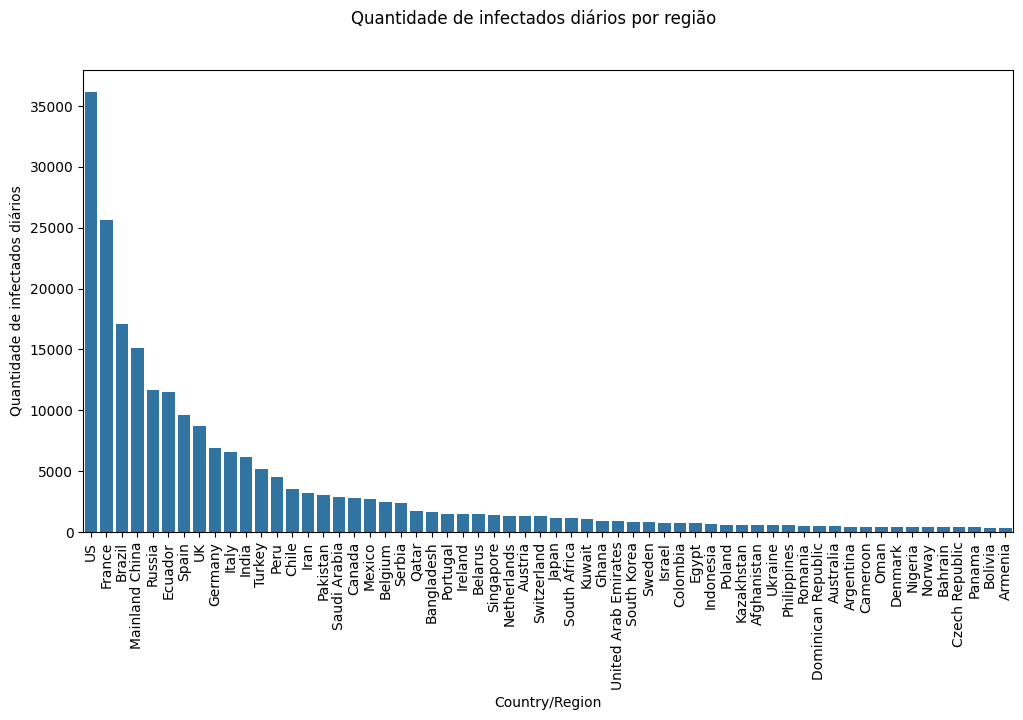

In [12]:
plot_picos_regiao(data=df_transformed,coluna='New_Confirmed',
                  y_label='infectados diários',largests=60)

In [13]:
df_global = transformation_pipeline(df,regiao='Global')
df_global

,ObservationDate,Confirmed,Recovered,Deaths,New_Confirmed,New_Recovered,New_Deaths,Confirmed_rate,Recovered_rate,Deaths_rate,Reproduction_rate
0,2020-01-22,555.0,28.0,17.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,2020-01-23,653.0,30.0,18.0,98.0,2.0,1.0,0.176577,0.071429,0.058824,1.355652
2,2020-01-24,941.0,36.0,26.0,288.0,6.0,8.0,0.441041,0.200000,0.444444,0.684375
3,2020-01-25,1438.0,39.0,42.0,497.0,3.0,16.0,0.528162,0.083333,0.615385,0.755901
4,2020-01-26,2118.0,52.0,56.0,680.0,13.0,14.0,0.472879,0.333333,0.333333,0.709318
...,...,...,...,...,...,...,...,...,...,...,...
114,2020-05-15,4542347.0,1637067.0,307666.0,100184.0,49174.0,5248.0,0.022553,0.030968,0.017353,0.466727
115,2020-05-16,4634068.0,1693197.0,311781.0,91721.0,56130.0,4115.0,0.020192,0.034287,0.013375,0.423660
116,2020-05-17,4713620.0,1733963.0,315185.0,79552.0,40766.0,3404.0,0.017167,0.024076,0.010918,0.490560
117,2020-05-18,4801943.0,1786875.0,318481.0,88323.0,52912.0,3296.0,0.018738,0.030515,0.010457,0.457328


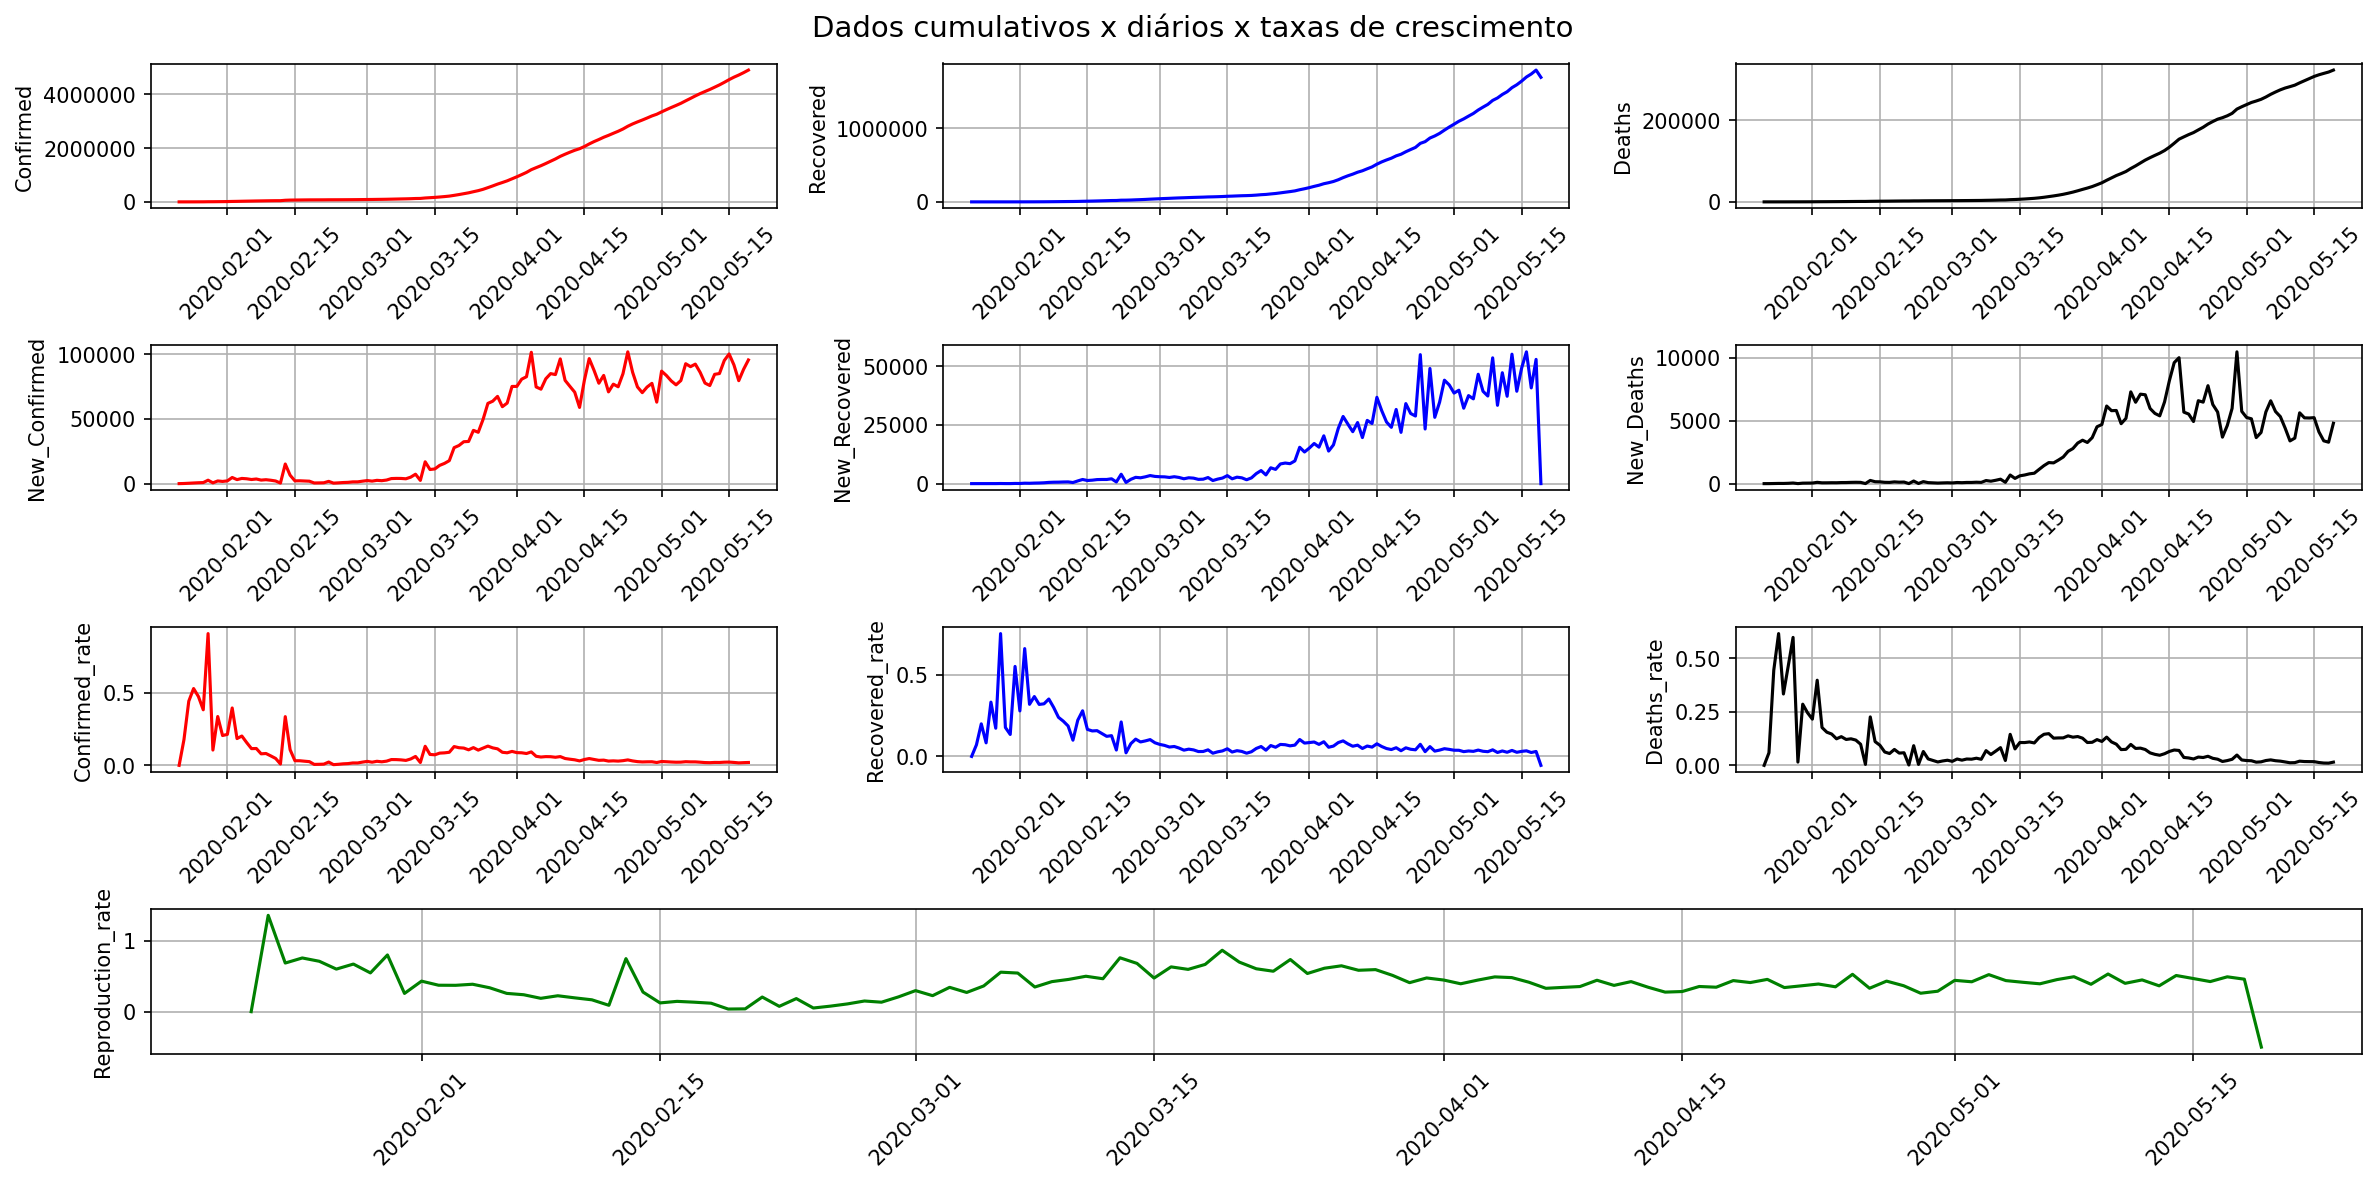

In [14]:
plot_dados_regiao(df_global)


 - Durante a data de **25/05/2020** a taxa de recuperação global é **negativa**, indicando assim uma **falta ou atraso** na coleta de dados de alguma das fontes durante essa data.

# EDA e análises nível regional

In [15]:
df_br = transformation_pipeline(df,'Brazil')
df_br.head()

,ObservationDate,Confirmed,Recovered,Deaths,New_Confirmed,New_Recovered,New_Deaths,Confirmed_rate,Recovered_rate,Deaths_rate,Reproduction_rate
1769,2020-02-26,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1770,2020-02-27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1771,2020-02-28,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1772,2020-02-29,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1773,2020-03-01,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


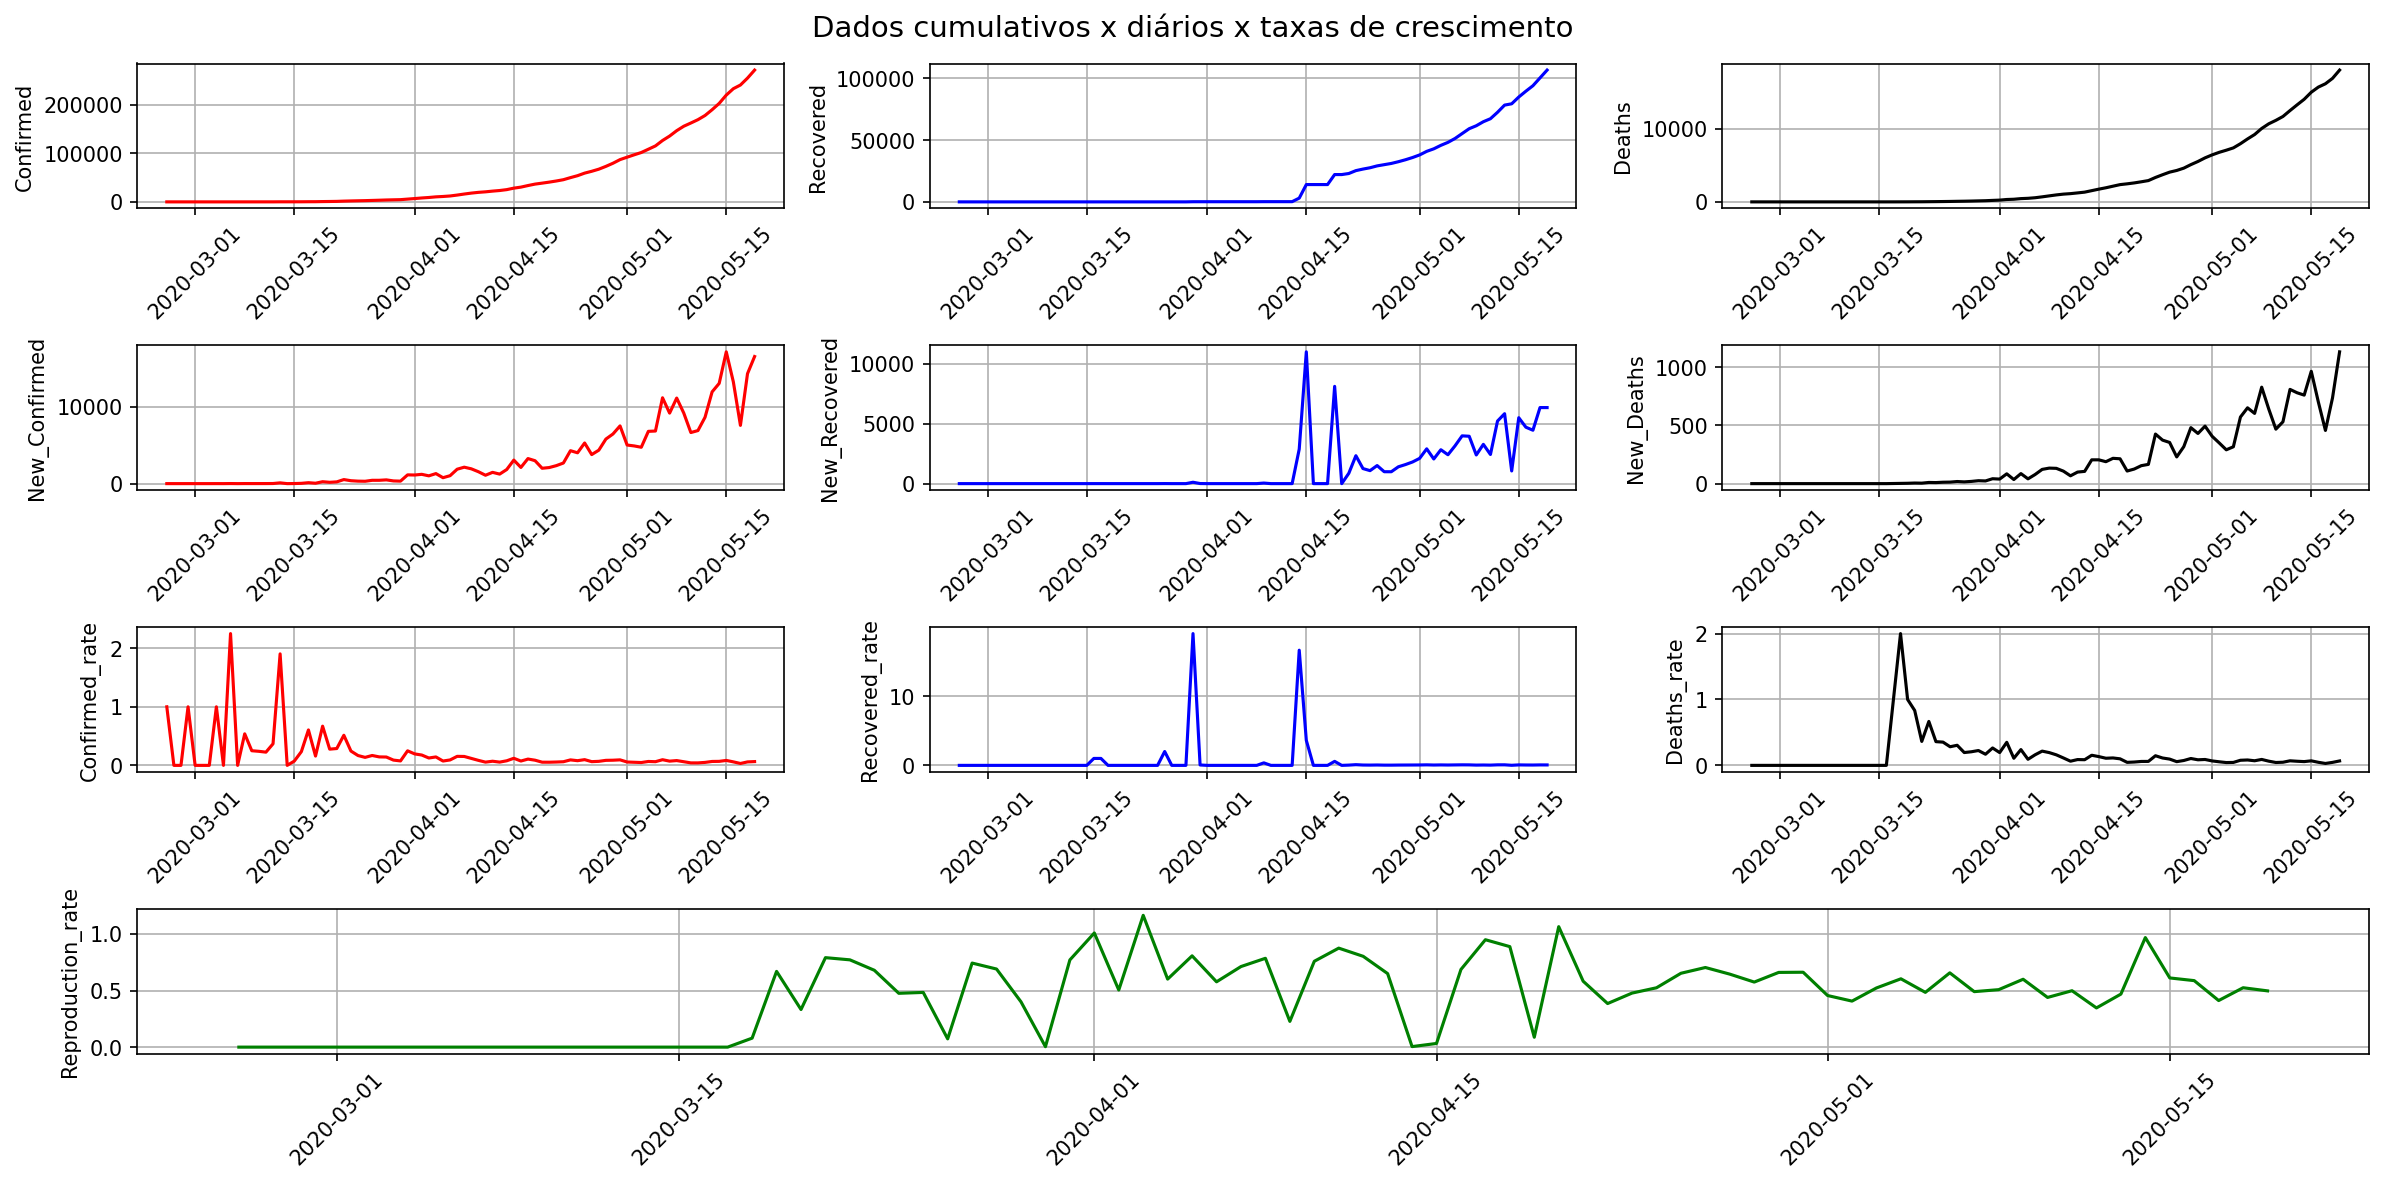

In [16]:
plot_dados_regiao(df_br)


- A partir de 15/04/2020 ocorreram **picos de novos casos recuperados** podendo indicar o começo das campanhas de vacinação, ou aumento da eficácia no tratamento da doença.
- Na mesma data também aumentaram os números de novos casos que levaram à morte, assim como o aumento de infectados.
- O índice de reprodução da doença começou a se manter estável em **50%**

In [17]:
save_path = '../data/preprocessed/covid_19_preprocessed.csv'
df_br.to_csv(save_path)

# Análise das séries temporais

In [18]:
df_br.head(3)

,ObservationDate,Confirmed,Recovered,Deaths,New_Confirmed,New_Recovered,New_Deaths,Confirmed_rate,Recovered_rate,Deaths_rate,Reproduction_rate
1769,2020-02-26,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1770,2020-02-27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1771,2020-02-28,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


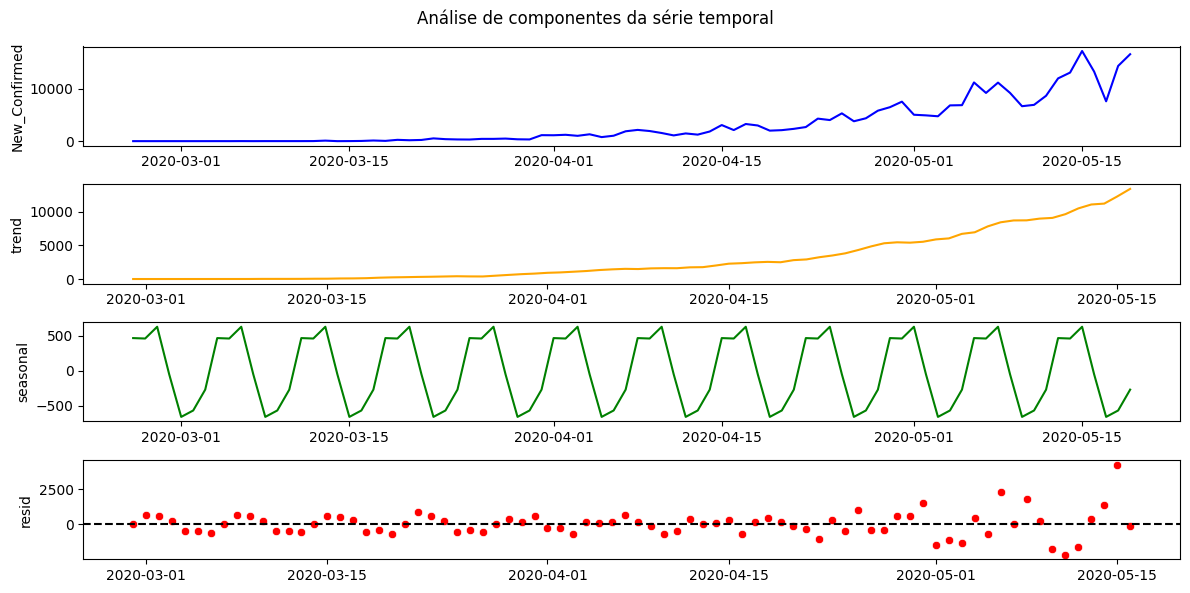

In [19]:
decompor_series(df_br,'New_Confirmed')

- Para os novos casos infectados a tendência é crescente até o momento da última extração de dados
- A seasonalidade indica intervalos regulares de 7 em 7 dias, que coincide com a informação que a aparição dos sintomas ocorre de 2 à 14 dias após contrair o vírus.